Fitting 5 folds for each of 24 candidates, totalling 120 fits


/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estim

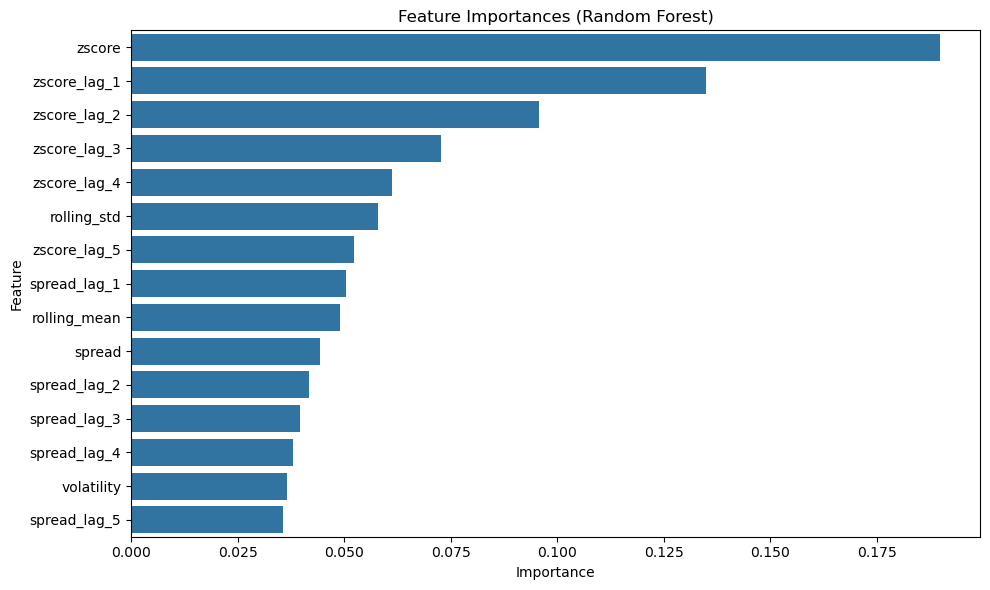

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

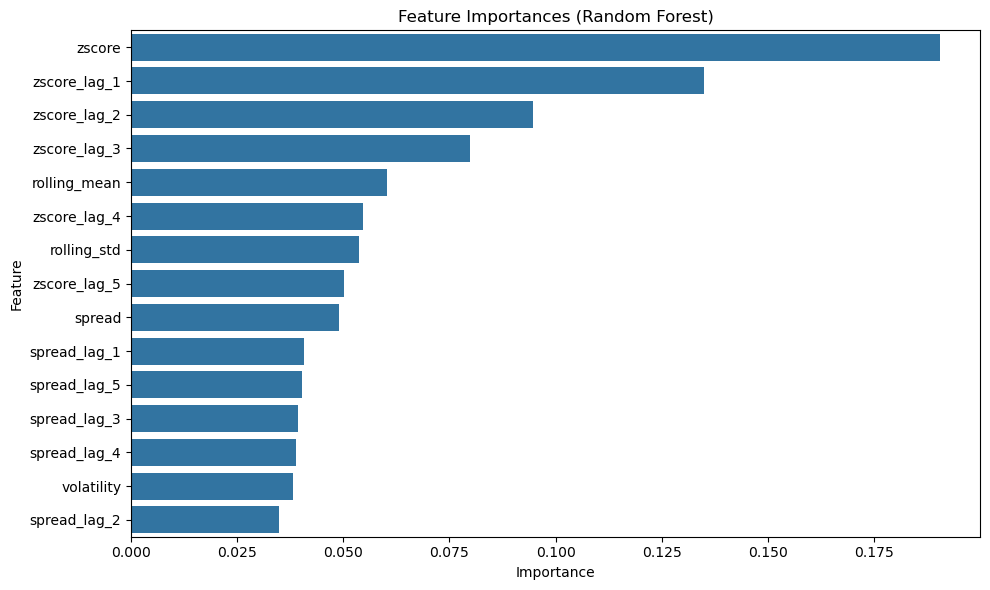

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

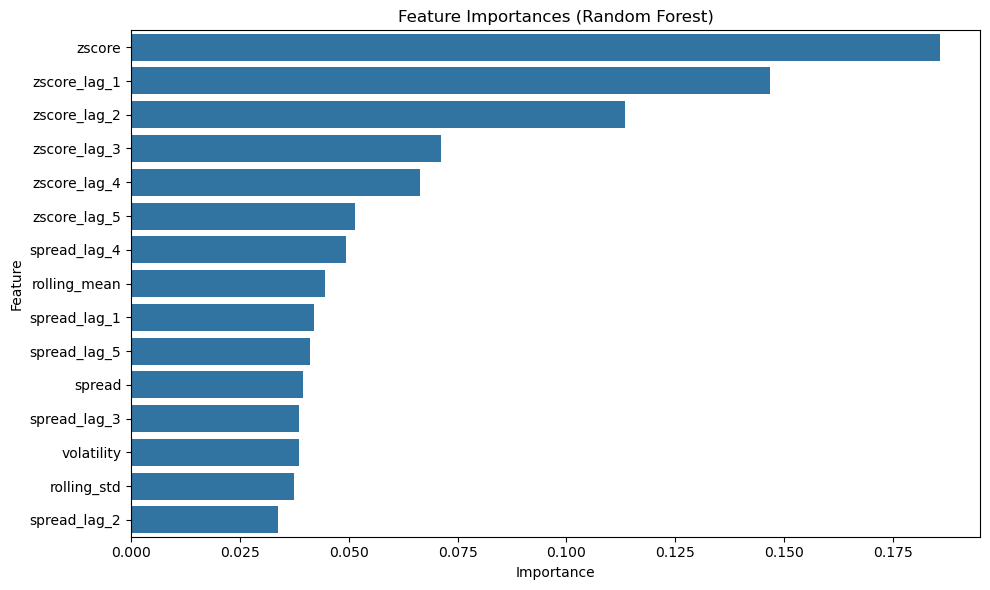

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

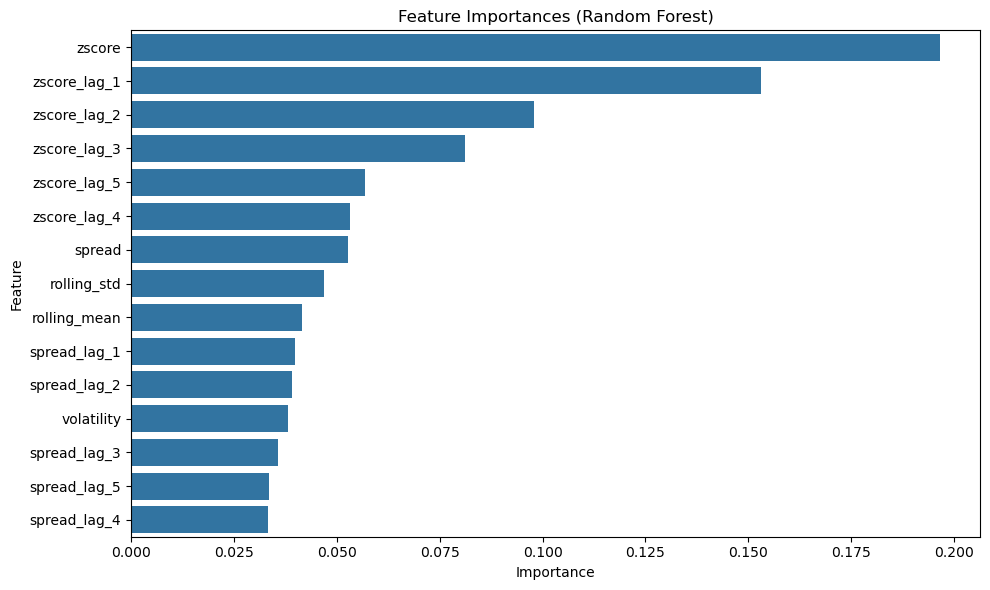

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

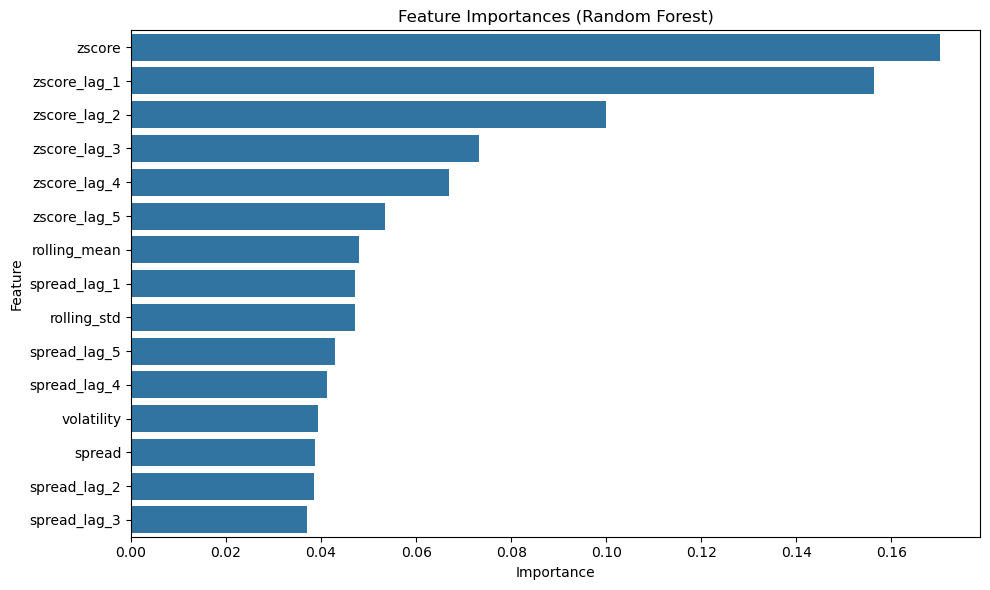

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

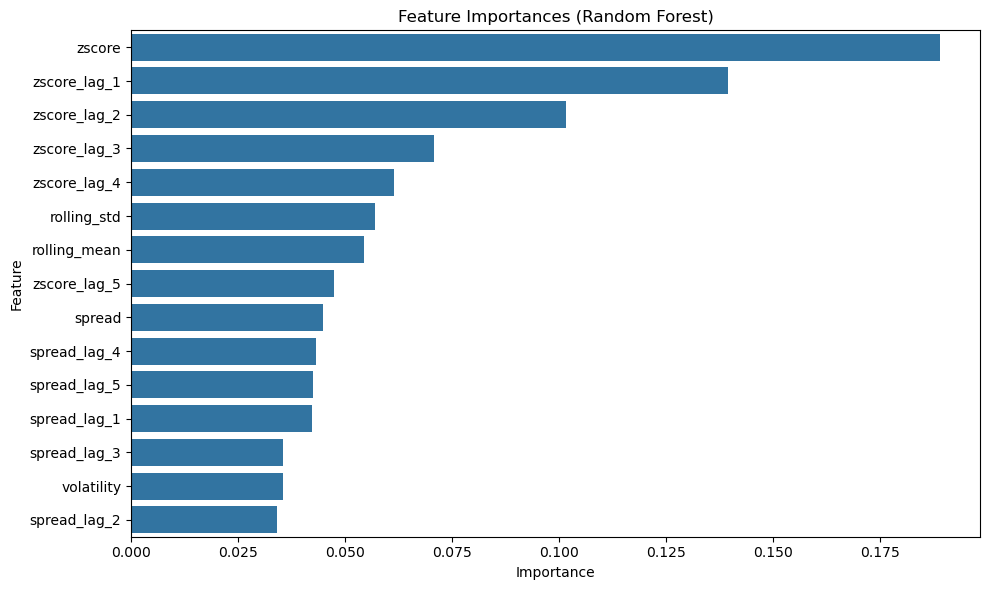

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

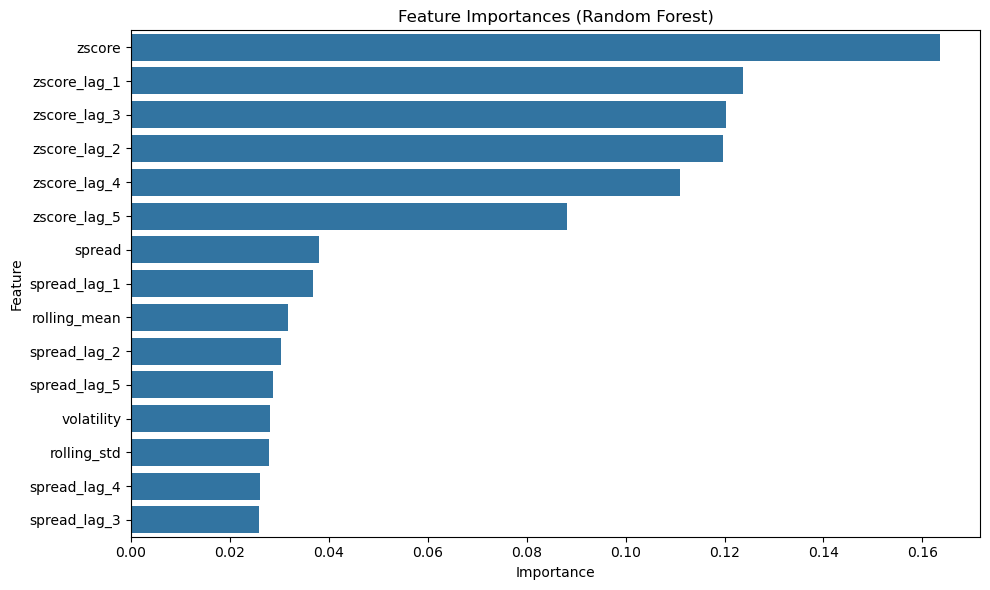

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

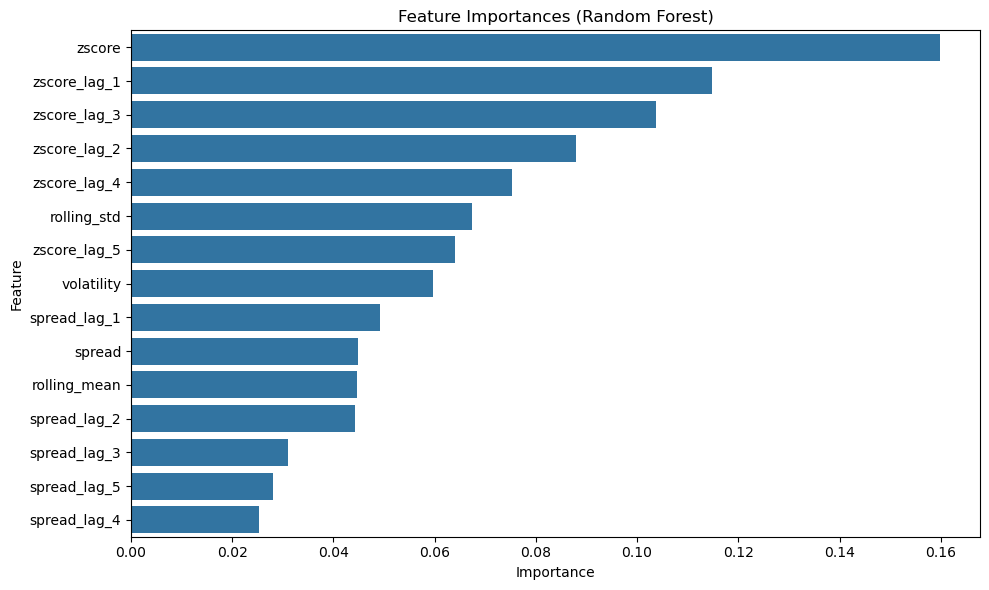

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

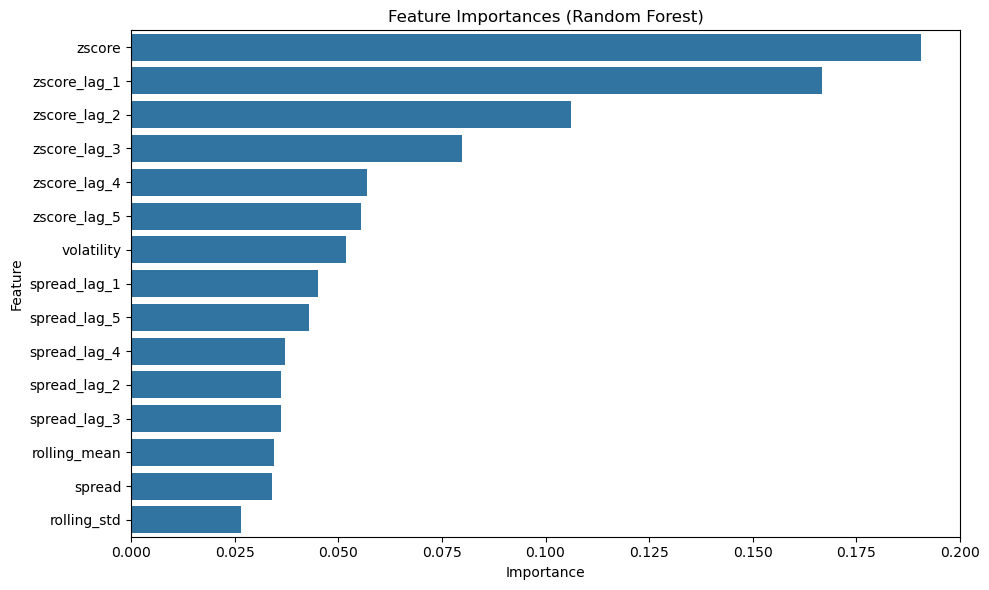

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

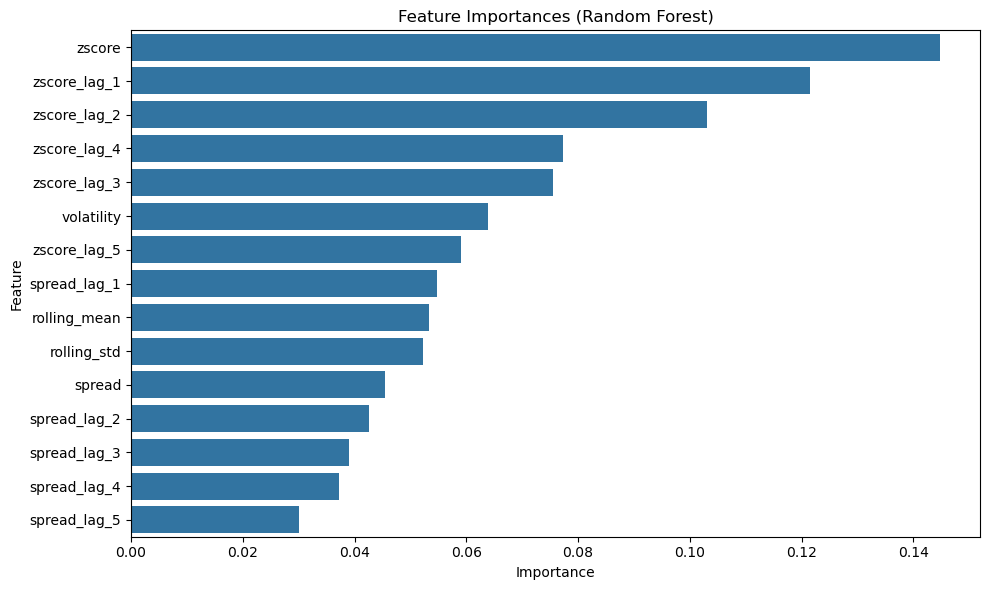

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

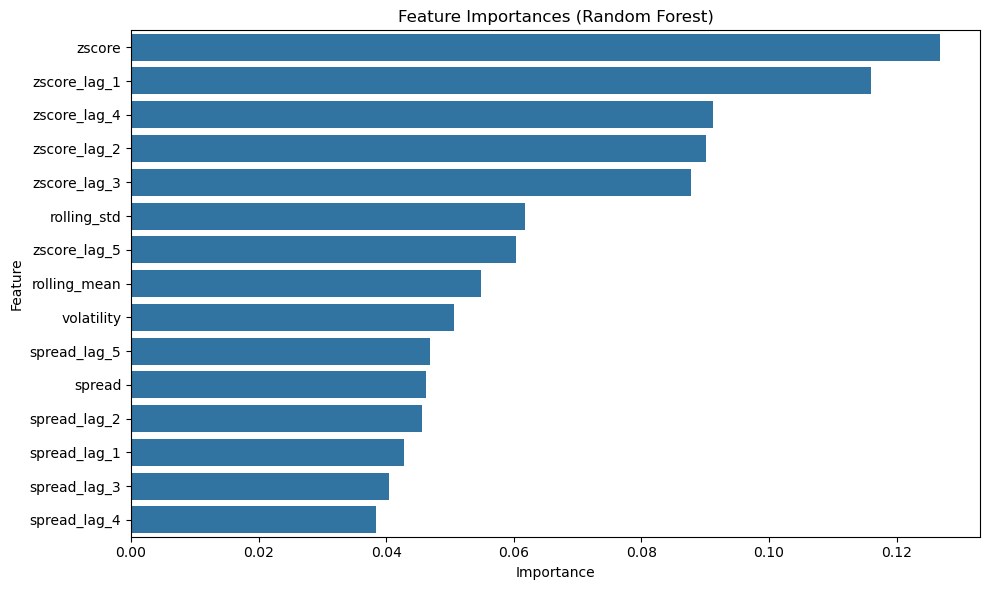

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

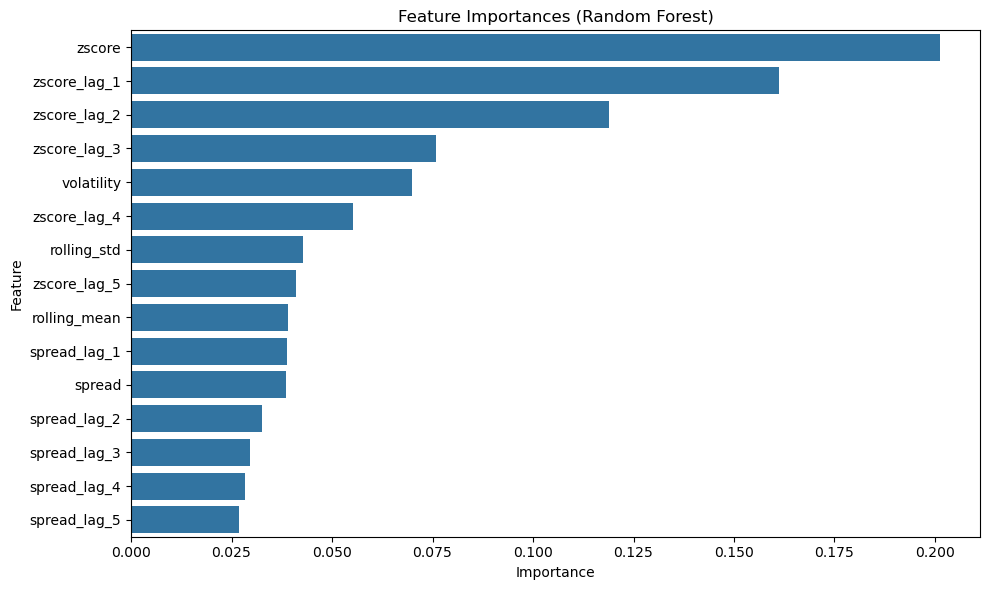

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END ma

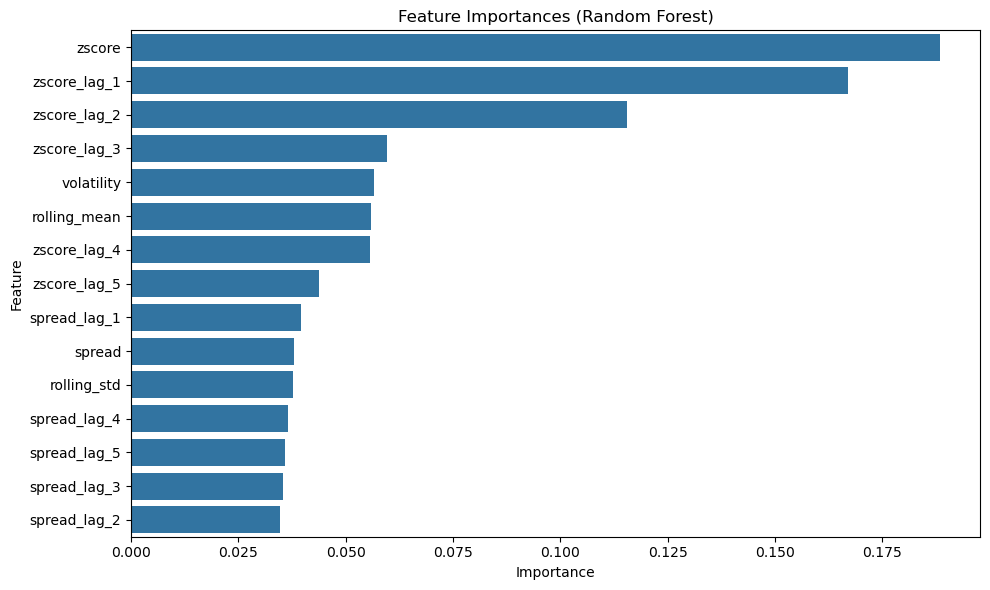

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END ma

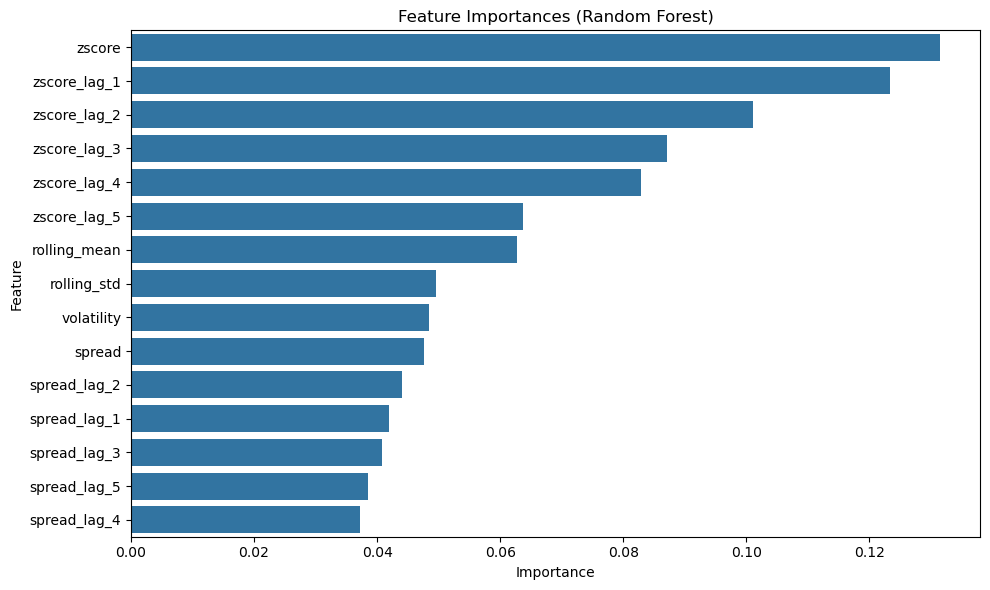

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_64844/187160743.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END ma

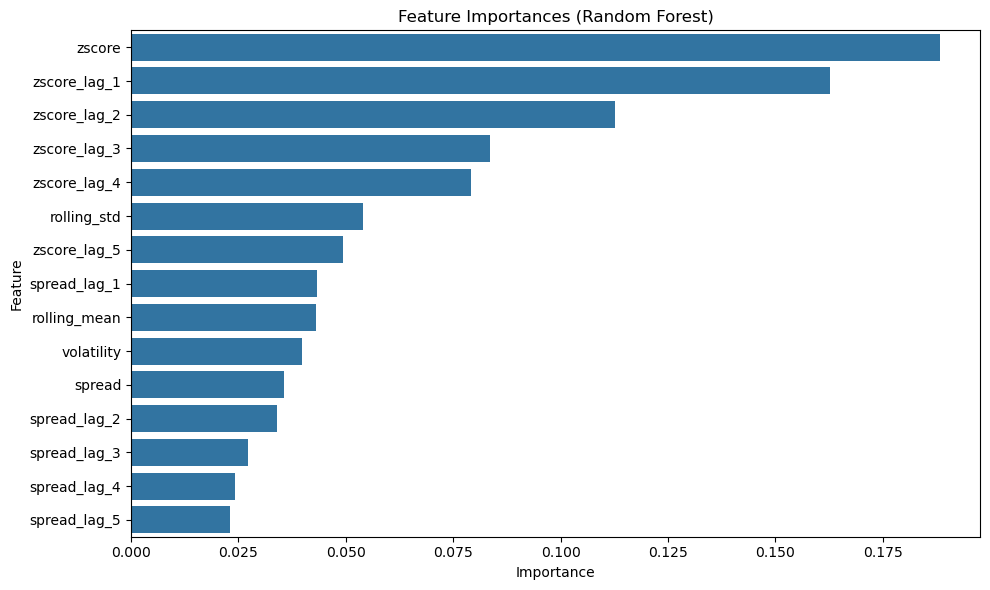

In [1]:
import pandas as pd
import numpy as np, random, os
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

etf_pairs = [('VO','IWB'), 
         ('VO','SPY'), 
         ('VO','SCHX'), 
         ('VO','SPLG'), 
         ('VO', 'IVV'),
         ('VO', 'VOO'), 
         ('DVY','IWR'), 
         ('SCHV', 'SPHQ'), 
         ('IWR','DIA'), 
         ('DVY','OEF'), 
         ('VTV', 'SPHQ'), 
         ('RSP', 'DIA'), 
         ('VO', 'DIA'), 
         ('DVY', 'FVD'), 
         ('DVY','VYM')] # closing

train_prices = pd.read_csv("etf_train_prices.csv", index_col = 0, parse_dates = True)
test_prices = pd.read_csv("etf_test_prices.csv", index_col = 0, parse_dates = True)

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window=z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def process_pair(etf1, etf2, price_data, lookback = 60):
    df = pd.DataFrame(index=price_data.index)
    df["etf1"] = price_data[etf1]
    df["etf2"] = price_data[etf2]

    df["hedge_ratio"] = (
        df["etf1"].rolling(lookback).cov(df["etf2"]) /
        df["etf2"].rolling(lookback).var()
    )

    df["spread"] = df["etf1"] - df["hedge_ratio"] * df["etf2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    df["rolling_mean"] = spread_mean
    df["rolling_std"] = spread_std
    df["volatility"] = df["spread"].pct_change().rolling(lookback).std()

    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    labels = predict_mean_reversion_label(df['spread'])
    idx = df.index.intersection(labels.index)
    df = df.loc[idx].copy()
    df['target'] = labels.loc[idx]

    df["pair"] = f"{etf1}_{etf2}"

    return df.dropna()

def find_beta(asset1, asset2):
    X = sm.add_constant(asset2)
    model = sm.OLS(asset1, X).fit()
    beta = model.params[1]
    return beta

feature_cols = [
    'spread', 'zscore',
    'rolling_mean', 'rolling_std', 'volatility',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

cv = TimeSeriesSplit(n_splits = 5)

pair_models = {}
pair_betas = {}

for etf1, etf2 in etf_pairs:
    pair_name = f"{etf1}_{etf2}"

    train_pair = process_pair(etf1, etf2, train_prices)
    beta = find_beta(train_pair["etf1"], train_pair["etf2"])
    pair_betas[pair_name] = beta
    test_pair = process_pair(etf1, etf2, test_prices)

    X_train, y_train = train_pair[feature_cols], train_pair["target"]
    X_test, y_test = test_pair[feature_cols], test_pair["target"]

    grid_search = GridSearchCV(
        estimator = RandomForestClassifier(random_state = 42,
                                           n_jobs = 1,
                                           bootstrap = True,
                                           class_weight = "balanced"),
        param_grid = param_grid,
        cv = cv,
        scoring = 'f1',
        n_jobs = -1,
        verbose = 2,
    )

    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    pair_models[pair_name] = best_rf

    print("\nBest Parameters:", grid_search.best_params_)

    y_pred = best_rf.predict(X_test)
    y_pred_probs = best_rf.predict_proba(X_test)[:, 1]

    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("True Label Distribution:", Counter(y_test))
    print("Predicted Label Distribution:", Counter(y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    importances = best_rf.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
    plt.title('Feature Importances (Random Forest)')
    plt.tight_layout()
    plt.show()

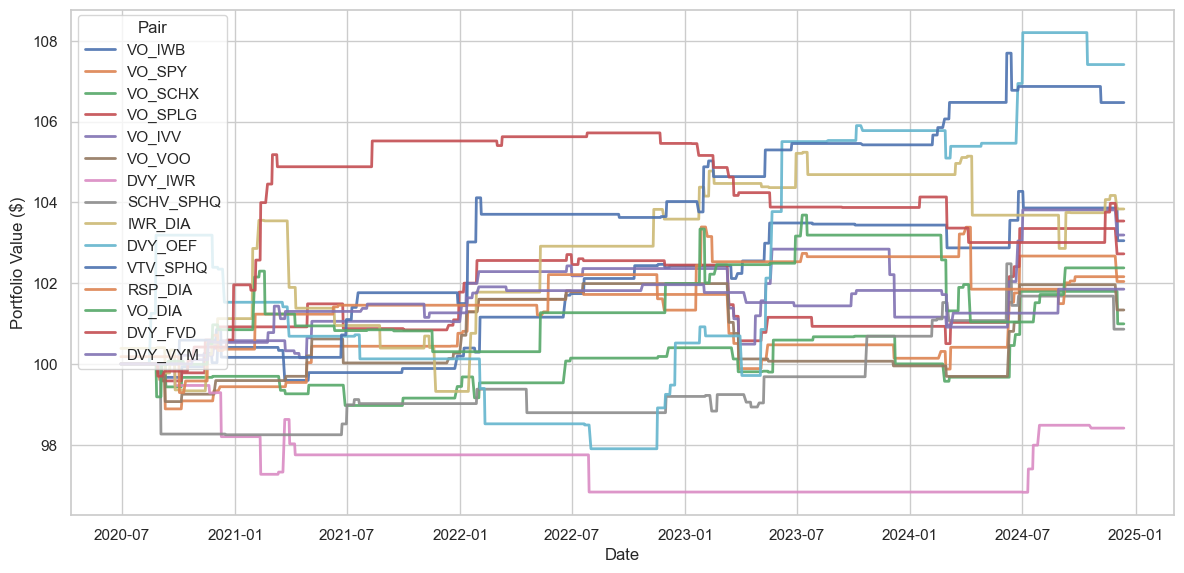

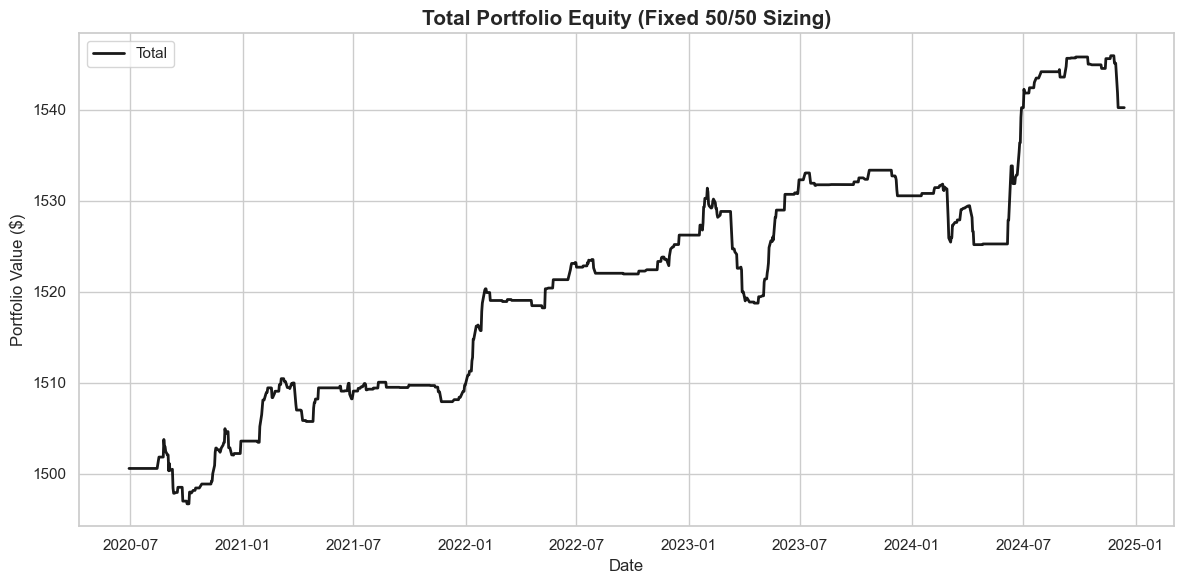

Summary
VO_IWB: Final Value = $103.05, Total Return = 3.05%, Trades = 32
VO_SPY: Final Value = $102.04, Total Return = 2.04%, Trades = 29
VO_SCHX: Final Value = $100.99, Total Return = 0.99%, Trades = 30
VO_SPLG: Final Value = $102.73, Total Return = 2.73%, Trades = 30
VO_IVV: Final Value = $103.19, Total Return = 3.19%, Trades = 29
VO_VOO: Final Value = $101.34, Total Return = 1.34%, Trades = 27
DVY_IWR: Final Value = $98.41, Total Return = -1.59%, Trades = 15
SCHV_SPHQ: Final Value = $100.86, Total Return = 0.86%, Trades = 25
IWR_DIA: Final Value = $103.84, Total Return = 3.44%, Trades = 43
DVY_OEF: Final Value = $107.41, Total Return = 7.41%, Trades = 33
VTV_SPHQ: Final Value = $106.47, Total Return = 6.47%, Trades = 30
RSP_DIA: Final Value = $102.16, Total Return = 1.98%, Trades = 28
VO_DIA: Final Value = $102.38, Total Return = 2.38%, Trades = 33
DVY_FVD: Final Value = $103.54, Total Return = 3.54%, Trades = 31
DVY_VYM: Final Value = $101.85, Total Return = 1.85%, Trades = 25

Tot

In [2]:
def simulate_pair(
    pair_df, 
    initial_cash_per_pair = 100.0, 
    holding_period = 5, 
    entry_threshold = 1.8, 
    use_compounding = False,
    sizing_mode = "dollar"
):
    df = pair_df.sort_index().copy()
    pair_name = df["pair"].iloc[0]
    cash = float(initial_cash_per_pair)
    df["beta"] = pair_betas[pair_name]

    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = initial_cash_per_pair
    equity.iloc[:] = np.nan
    equity.iloc[0] = initial_cash_per_pair

    trades = []
    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row["prob"]

        if (prob >= 0.5) and (abs(row["zscore"]) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price1_in, price2_in = row["etf1"], row["etf2"]
            price1_out, price2_out = df.iloc[exit_idx]["etf1"], df.iloc[exit_idx]["etf2"]

            notional = cash if use_compounding else initial_cash_per_pair

            if (sizing_mode == "dollar"):
                long_dollars, short_dollars = notional * 0.5, notional * 0.5

                if row["zscore"] > 0:
                    shares_short1 = short_dollars / price1_in
                    shares_long2  = long_dollars / price2_in
                    pnl = (shares_long2 * (price2_out - price2_in)) + (shares_short1 * (price1_in - price1_out))
                    direction = "Short ETF1 / Long ETF2"
                else:
                    shares_long1  = long_dollars / price1_in
                    shares_short2 = short_dollars / price2_in
                    pnl = (shares_long1 * (price1_out - price1_in)) + (shares_short2 * (price2_in - price2_out))
                    direction = "Long ETF1 / Short ETF2"

            elif (sizing_mode == "hedge"):
                beta = abs(float(df["beta"].iloc[0]))

                q = notional / (price1_in + beta * price2_in)

                if row["zscore"] > 0:
                    shares_short1 = q
                    shares_long2  = beta * q
                    pnl = (shares_long2 * (price2_out - price2_in)) + (shares_short1 * (price1_in - price1_out))
                    direction = "Short ETF1 / Long ETF2"
                else:
                    shares_long1  = q
                    shares_short2 = beta * q
                    pnl = (shares_long1 * (price1_out - price1_in)) + (shares_short2 * (price2_in - price2_out))
                    direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[entry_date:exit_date] = cash

            trades.append({
                "pair": pair_name,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": float(pnl),
                "notional": float(notional)
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades


pair_results = []
initial_cash_per_pair = 100.0

for etf1, etf2 in etf_pairs:
    pair_name = f"{etf1}_{etf2}"

    test_pair = process_pair(etf1, etf2, test_prices).copy()

    model = pair_models[pair_name]

    X_test_pair = test_pair[feature_cols]
    test_pair['prediction'] = model.predict(X_test_pair)
    test_pair['prob'] = model.predict_proba(X_test_pair)[:, 1]

    equity, trades = simulate_pair(test_pair, sizing_mode = "hedge")

    pair_results.append({
        "pair": pair_name,
        "equity": equity,
        "trades": trades,
        "final_value": equity.iloc[-1],
        "total_return": (equity.iloc[-1] / equity.iloc[0] - 1) * 100,
        "n_trades": len(trades)
    })

sns.set_theme(style="whitegrid", context="notebook")

plt.figure(figsize = (12, 6))
combined_equity = 0

for result in pair_results:
    sns.lineplot(
        x = result["equity"].index,
        y = result["equity"].values,
        label = result["pair"],
        linewidth = 2,
        alpha = 0.9
    )
    if isinstance(combined_equity, int):
        combined_equity = result["equity"]
    else:
        combined_equity = combined_equity.add(result["equity"], fill_value=0)

plt.xlabel("Date", fontsize = 12)
plt.ylabel("Portfolio Value ($)", fontsize = 12)
plt.legend(title = "Pair", frameon = True, loc = "center left", bbox_to_anchor = (0, 0.64))
plt.grid(True)
plt.tight_layout()
plt.savefig("/Users/ak/Downloads/RF_equity.pdf", dpi = 400, bbox_inches = "tight")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x = combined_equity.index,
    y = combined_equity.values,
    label = "Total",
    color = "black",
    linewidth = 2,
    alpha = 0.9
)
plt.title("Total Portfolio Equity (Fixed 50/50 Sizing)", fontsize = 15, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.legend(frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Summary")
for result in pair_results:
    print(f"{result['pair']}: Final Value = ${result['final_value']:.2f}, "
          f"Total Return = {result['total_return']:.2f}%, Trades = {result['n_trades']}")


initial_total_value = combined_equity.iloc[0]
final_total_value = combined_equity.iloc[-1]
total_return_pct = (final_total_value - initial_total_value) / initial_total_value * 100

print("\nTotal Portfolio Performance")
print(f"Initial Portfolio Value: ${initial_total_value:,.2f}")
print(f"Final Portfolio Value:   ${final_total_value:,.2f}")
print(f"Total Return:            {total_return_pct:.2f}%")

combined_equity.to_csv("equity_curves/random_forest_equity.csv", header=["Portfolio Value"])


In [3]:
def compute_sharpe_ratio(equity_series):
    daily_returns = equity_series.pct_change().dropna()
    mean_return = daily_returns.mean()
    std_return = daily_returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else np.nan
    return sharpe

print("\nSharpe Ratios")
for result in pair_results:
    sharpe = compute_sharpe_ratio(result["equity"])
    result["sharpe"] = sharpe
    print(f"{result['pair']}: Sharpe Ratio = {sharpe:.2f}")

portfolio_sharpe = compute_sharpe_ratio(combined_equity)
print(f"\nTotal Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")



Sharpe Ratios
VO_IWB: Sharpe Ratio = 0.64
VO_SPY: Sharpe Ratio = 0.39
VO_SCHX: Sharpe Ratio = 0.20
VO_SPLG: Sharpe Ratio = 0.47
VO_IVV: Sharpe Ratio = 0.51
VO_VOO: Sharpe Ratio = 0.26
DVY_IWR: Sharpe Ratio = -0.29
SCHV_SPHQ: Sharpe Ratio = 0.14
IWR_DIA: Sharpe Ratio = 0.35
DVY_OEF: Sharpe Ratio = 0.69
VTV_SPHQ: Sharpe Ratio = 0.97
RSP_DIA: Sharpe Ratio = 0.31
VO_DIA: Sharpe Ratio = 0.30
DVY_FVD: Sharpe Ratio = 0.59
DVY_VYM: Sharpe Ratio = 0.57

Total Portfolio Sharpe Ratio: 1.21


In [4]:
def compute_max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    print(f"\nMax Drawdown: {max_drawdown:.2%}")
    return max_drawdown

max_drawdown = compute_max_drawdown(combined_equity)



Max Drawdown: -0.83%
